# Solving 2D homography from 4 points correspondences

Small experiment to solve a 2D homography turning any quadrilateral into another quadrilateral

In [1]:
import numpy as np
import numpy.linalg as la
import pylab as pl
%matplotlib inline
np.set_printoptions(suppress=True, precision=5)

In [2]:
# Source and target quadrilaterals
x = np.array([
    [2, 2],
    [2, 4],
    [4, 4],
    [4, 2]
])

xp = np.array([
    [2, 2],
    [2.5, 4],
    [3.5, 3.5],
    [4, 2]
])

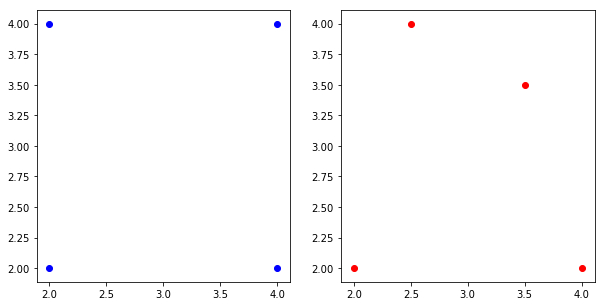

In [3]:
pl.figure(figsize=(10, 5))
pl.subplot(121)
pl.scatter(x[:,0], x[:,1], c='b')
pl.subplot(122)
pl.scatter(xp[:,0], xp[:,1], c='r')

## Solving for the homography

See _Hartley & Zissermann "Multiple view geometry in computer vision"_, section 4.1 and equation 4.3 for reference.

We want to solve for the homography $H$ such that
$$x_i' = Hx_i$$
Which can be rewritten as a cross product
$$x_i' \times Hx_i = 0$$

With the $j-th$ row of H denoted as $h^{jT}$, then we have

$$Hx_i = \left( \begin{array}{c} h^{1T}x_i \\ h^{2T}x_i \\ h^{3T}x_i\end{array} \right)$$

So now the cross-product above can be rewritten (assuming $x_i'(k)$ denotes the k-th coordinate of $x_i'$)

$$
x_i' \times Hx_i = \left(
  \begin{array}{c}
  x_i'(1) h^{3T}x_i - x_i'(2) h^{2T}x_i \\
  x_i'(2) h^{1T}x_i - x_i'(0) h^{3T}x_i \\
  x_i'(0) h^{2T}x_i - x_i'(1) h^{1T}x_i
  \end{array} \right)
$$

Since $h^{jT}x_i = x_i^T h^j$, we can rewrite as

$$
\left(
\begin{array}{c c c}
0^T & -x_i'(2)x_i^T & x_i'(1)x_i^T \\
x_i'(2)x_i^T & 0^T & -x_i'(0)x_i^T \\
-x_i'(1)x_i^T & x_i'(0)x_i^T & 0^T
\end{array}
\right)
\
\left(
\begin{array}{c}
h^1 \\
h^2 \\
h^3
\end{array}
\right)
\
=0
$$

Note that this is a 3x9 matrix multiplying a 9x1 vector containing the unknown (the row of H).

The third row can be obtaine as a combination of first and second and therefore we can drop it, so we have two remaining equations per point
$$
\left(
\begin{array}{c c c}
0^T & -x_i'(2)x_i^T & x_i'(1)x_i^T \\
x_i'(2)x_i^T & 0^T & -x_i'(0)x_i^T
\end{array}
\right)
\
\left(
\begin{array}{c}
h^1 \\
h^2 \\
h^3
\end{array}
\right)
\
=0
$$

Which we'll solve as an $Ah = 0$ problem

In [4]:
def compute_A_for_point(x, xp):
    """
    Computes two rows of A for a single point correspondence x and xp
    """
    assert len(x) == len(xp) == 2
    # convert to homogeneous
    x = np.r_[x, 1]
    xp = np.r_[xp, 1]
    
    return np.array([
        np.r_[np.zeros(3), -xp[2] * x , xp[1] * x],
        np.r_[xp[2] * x  , np.zeros(3), -xp[0] * x]
    ])

def compute_homography(x, xp):
    """
    Given two arrays of corresponding points as 4x2 arrays, compute the
    homography H such that xp = Hx
    """
    A = np.concatenate([compute_A_for_point(*pair) for pair in zip(x, xp)], axis=0)
    U, s, V = la.svd(A)
    # Solution is the last row of V (corresponding to the smallest eigenvalue)
    H = np.reshape(V[-1], (3, 3))
    return H
    
compute_A_for_point(x[0], xp[0])
H = compute_homography(x, xp)

print(H)

[[-0.22664 -0.17434  0.62761]
 [-0.06973 -0.33124  0.62761]
 [-0.03487 -0.06102  0.1046 ]]


In [5]:
def hdot(M, p):
    """Convenience function to apply a 3x3 transform to a 2D point"""
    pp = M.dot(np.r_[p, 1]) # to homogeneous
    return pp[:-1] / pp[-1] # back to inhomogeneous

for i in range(4):
    print("-- %d" % i)
    print("x  = %s" % x[i])
    print("xp = %s" % xp[i])
    print("Hx = %s" % (hdot(H, x[i])))
    assert np.allclose(hdot(H, x[i]), xp[i])

-- 0
x  = [2 2]
xp = [ 2.  2.]
Hx = [ 2.  2.]
-- 1
x  = [2 4]
xp = [ 2.5  4. ]
Hx = [ 2.5  4. ]
-- 2
x  = [4 4]
xp = [ 3.5  3.5]
Hx = [ 3.5  3.5]
-- 3
x  = [4 2]
xp = [ 4.  2.]
Hx = [ 4.  2.]
